# Exploratory Data Analysis (EDA)
## nPulse Sensor Data Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading

In [2]:
# Load sample cleaned data
data_path = Path('../data/data_rpi/cleaned')
csv_files = list(data_path.glob('*.csv'))
print(f"Found {len(csv_files)} cleaned CSV files")

# Load first file as sample
df = pd.read_csv(csv_files[0])
print(f"\nLoaded: {csv_files[0].name}")
print(f"Shape: {df.shape}")
df.head()

Found 7 cleaned CSV files

Loaded: WS_R_ch3_seq4_250523180349_cleaned.csv
Shape: (15902, 5)


,Timestamp,Channel1,Channel2,Channel3,Gesture
0,0.279,3.946817,0.194623,681.394175,0
1,0.282,5.675466,0.245992,686.785627,0
2,0.285,6.554836,0.420930,703.497450,0
3,0.288,5.612703,0.182997,698.442861,0
4,0.291,2.819258,0.234051,689.405650,0


## 2. Data Overview

In [3]:
# Basic information
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nStatistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15902 entries, 0 to 15901
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  15902 non-null  float64
 1   Channel1   15902 non-null  float64
 2   Channel2   15902 non-null  float64
 3   Channel3   15902 non-null  float64
 4   Gesture    15902 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 621.3 KB
None


Statistical Summary:


,Timestamp,Channel1,Channel2,Channel3,Gesture
count,15902.000000,1.590200e+04,1.590200e+04,15902.000000,15902.000000
mean,24.339146,-1.228521e-13,9.052338e-14,682.020140,4.560433
std,13.879856,2.384461e+01,2.906122e-01,13.001023,5.260818
min,0.279000,-2.332713e+02,-3.329010e+00,596.755231,0.000000
25%,12.323750,-6.424020e+00,-8.604137e-02,672.346580,0.000000
50%,24.349500,-5.185535e-01,4.908670e-02,681.984943,0.000000
75%,36.365250,5.772738e+00,1.496949e-01,691.825691,9.000000
max,48.259000,3.832103e+02,5.288116e+00,772.669325,14.000000


In [4]:
# Check for missing values and unique gestures
print("Missing Values:")
print(df.isnull().sum())
print(f"\nUnique Gestures: {df['Gesture'].unique()}")
print(f"Gesture Distribution:\n{df['Gesture'].value_counts()}")

Missing Values:
Timestamp    0
Channel1     0
Channel2     0
Channel3     0
Gesture      0
dtype: int64

Unique Gestures: [ 0 14 13  9 10  6  5]
Gesture Distribution:
Gesture
0     8249
13    1353
5     1318
9     1279
6     1253
10    1247
14    1203
Name: count, dtype: int64


## 3. Visualization

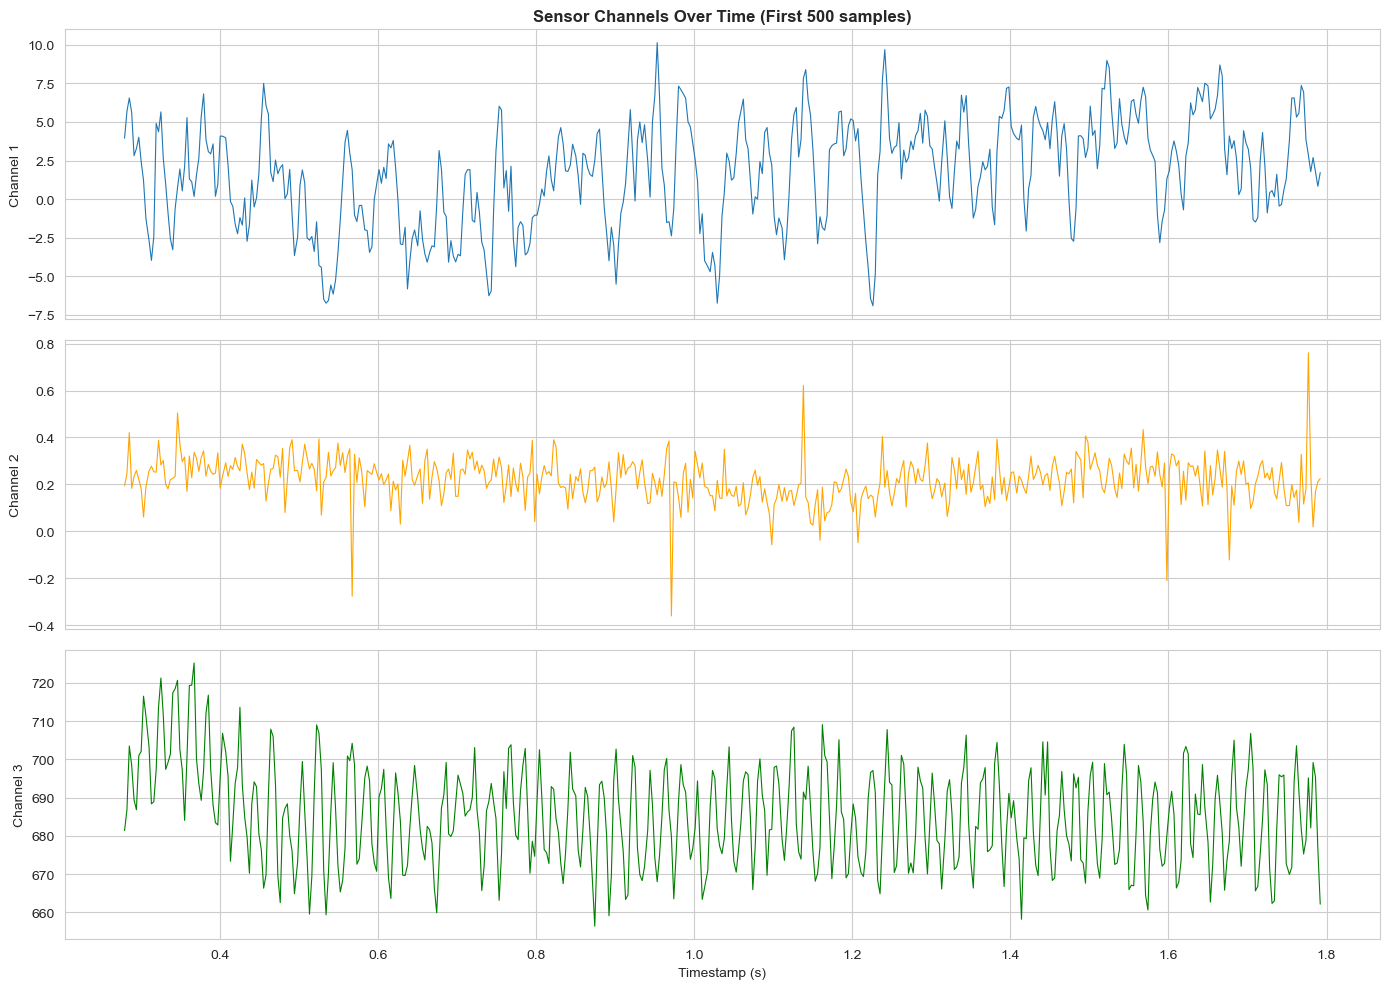

In [5]:
# Time series plot of sensor channels
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
sample_data = df.head(500)  # Plot first 500 samples for clarity

axes[0].plot(sample_data['Timestamp'], sample_data['Channel1'], linewidth=0.8)
axes[0].set_ylabel('Channel 1', fontsize=10)
axes[0].set_title('Sensor Channels Over Time (First 500 samples)', fontsize=12, fontweight='bold')

axes[1].plot(sample_data['Timestamp'], sample_data['Channel2'], linewidth=0.8, color='orange')
axes[1].set_ylabel('Channel 2', fontsize=10)

axes[2].plot(sample_data['Timestamp'], sample_data['Channel3'], linewidth=0.8, color='green')
axes[2].set_ylabel('Channel 3', fontsize=10)
axes[2].set_xlabel('Timestamp (s)', fontsize=10)

plt.tight_layout()
plt.show()

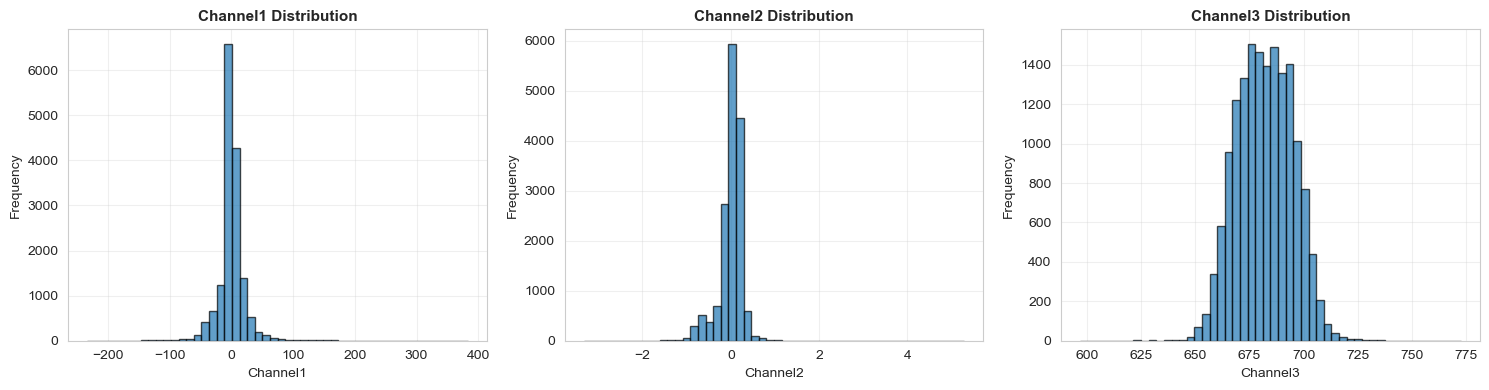

In [6]:
# Distribution of sensor channels
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, channel in enumerate(['Channel1', 'Channel2', 'Channel3']):
    axes[idx].hist(df[channel], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(channel, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{channel} Distribution', fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

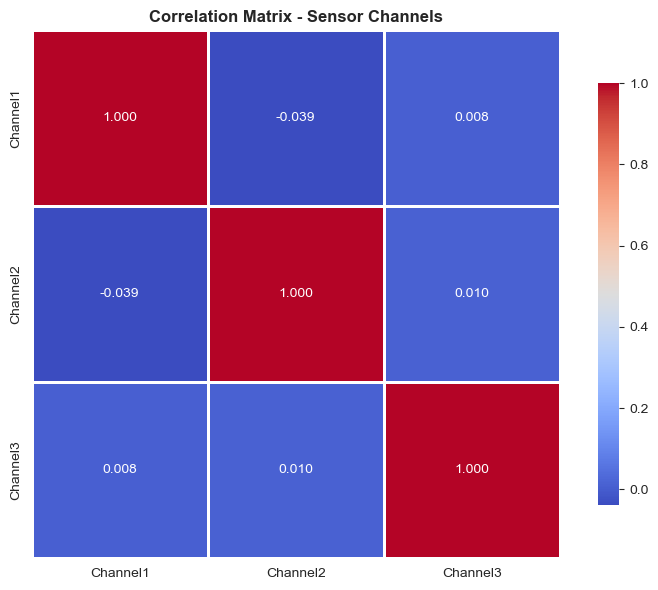


Correlation Matrix:
          Channel1  Channel2  Channel3
Channel1  1.000000 -0.039463  0.008355
Channel2 -0.039463  1.000000  0.010480
Channel3  0.008355  0.010480  1.000000


In [7]:
# Correlation heatmap
correlation_matrix = df[['Channel1', 'Channel2', 'Channel3']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Sensor Channels', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

## 4. Multi-file Analysis

In [8]:
# Load and analyze all cleaned files
all_data = []
for file in csv_files:
    if file.stat().st_size > 0:  # Skip empty files
        temp_df = pd.read_csv(file)
        temp_df['file'] = file.name
        all_data.append(temp_df)

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)
print(f"Total combined shape: {df_all.shape}")
print(f"\nGesture distribution across all files:")
print(df_all['Gesture'].value_counts())
print(f"\nFiles processed: {len(all_data)}")

Total combined shape: (110278, 6)

Gesture distribution across all files:
Gesture
0     58486
6      9043
10     8714
9      8637
5      8621
14     8424
13     8353
Name: count, dtype: int64

Files processed: 7


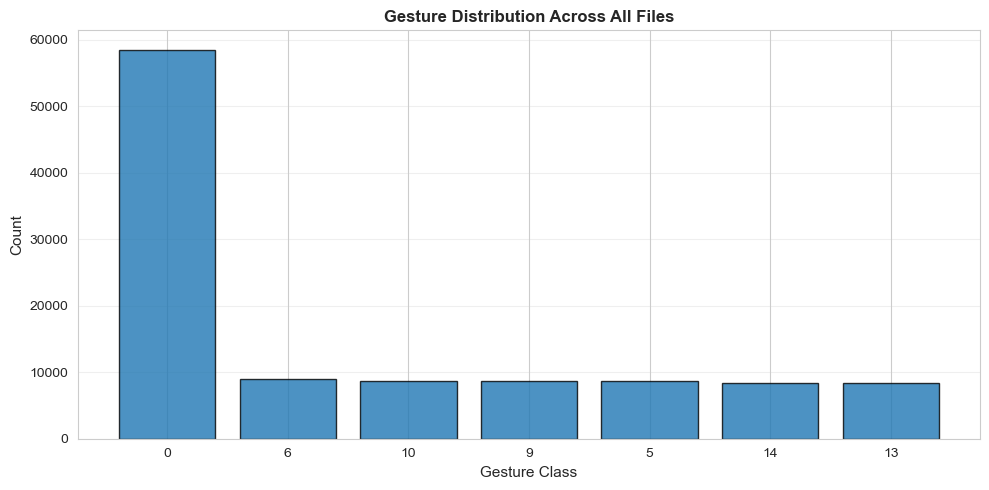

In [9]:
# Gesture distribution visualization
plt.figure(figsize=(10, 5))
gesture_counts = df_all['Gesture'].value_counts()
plt.bar(gesture_counts.index.astype(str), gesture_counts.values, edgecolor='black', alpha=0.8)
plt.xlabel('Gesture Class', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.title('Gesture Distribution Across All Files', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Key Findings

**Data Structure:**
- 3 sensor channels (Channel1, Channel2, Channel3)
- Timestamp column for temporal analysis
- Gesture labels for classification
- Multiple CSV files representing different recording sessions

**Observations:**
- Data appears to be from capacitive/proximity sensors
- Channel3 shows significantly larger magnitude values
- Temporal patterns visible in time-series data
- Multiple gesture classes present in the dataset